# Machine Learning Walkthrough: Predicting the World Cup #

*Sorin Peste (sorinpeste@gmail.com)*

## Intro ##

This is a walkthrough on using Machine Learning while trying to predict who is going to win the next [FIFA World Cup](http://www.fifa.com/worldcup/index.html).

We're going to use historical information about international football (soccer) matches to build a model, which is going to give us the ability to predict future match results.

Afterwards, we're going to use that model to run multiple simulations of the next World Cup tournament, and produce statistics about which teams are the most likely to win it all.

This document is meant for people who are new to Machine Learning, and want to better understand the data science process, as well as the R language.

> NOTE: If you attended any of my presentations about this walkthrough, you can find the [presentation slides here](http://slides.com/sorinpeste/fun-with-machine-learning/).

> NOTE 2: The GitHub containing all the code I used is [here](https://github.com/neaorin/PredictTheWorldCup). You can also find the Javascript code I used to acquire the [historical matches data](https://github.com/neaorin/PredictTheWorldCup/tree/master/acquisition/fifa) from the FIFA website, as well as the [Python program](https://github.com/neaorin/PredictTheWorldCup/blob/master/src/TournamentSim/simulateworldcup.py) which simulates the tournament thousands of times.  

## Customizing the Tutorial

If you want to do this walkthrough on your own machine, or if you'd like to customize it, you can clone this notebook by using the **Clone** button at the top of this page. This will copy the entire notebook into your own Azure Notebooks workspace, where you can edit it.

You can also find an [R source file containing the entire code](https://github.com/neaorin/PredictTheWorldCup/blob/master/src/WorldCup.R) on my GitHub repo. Open that with the editor of your choice - [RStudio](https://www.rstudio.com/) is a popular one.

With that out of the way, let's begin!

## The Process ##

Below is a typical workflow for a Data Science project such as ours.

![Data Science Project Workflow](https://raw.githubusercontent.com/neaorin/PredictTheWorldCup/master/images/datascience_process.jpg)

## Our Objective ##

The first step is defining an objective, an outcome for our model to predict:

> Given a match between two teams, what is the **expected goal differential** at the end of the match?

In other words, we're going to attempt to predict the `outcome` variable in the table below, which is the difference between the number of goals scored by `team1` and the number of goals scored by `team2`.

![Outcome - goal differential](https://raw.githubusercontent.com/neaorin/PredictTheWorldCup/master/images/goaldiff.png)

Let's note that the `outcome` value can be zero (for draws), positive (whenever `team1` wins) but also negative (whenever `team2` wins the match).

## The Data ##

### Matches ###

We're going to use a dataset containing more than 33 thousand international football matches played between 1950 and 2017. All these matches are played between senior men's national teams - there are no club matches, and no youth / women's games.

The dataset is available as [CSV](https://raw.githubusercontent.com/neaorin/PredictTheWorldCup/master/input/matches.csv) and [JSON](https://raw.githubusercontent.com/neaorin/PredictTheWorldCup/master/input/matches.json) files.

Below is a small sample from the JSON file:

```json
[
    {
        "date": "19560930",
        "team1": "AUT",
        "team1Text": "Austria",
        "team2": "LUX",
        "team2Text": "Luxembourg",
        "resText": "7-0",
        "statText": "",
        "venue": "Ernst Happel Stadium - Vienna , Austria",
        "IdCupSeason": "10",
        "CupName": "FIFA World Cup™ Qualifier",
        "team1Score": "7",
        "team2Score": "0"
    },
    {
        "date": "19561003",
        "team1": "IRL",
        "team1Text": "Republic of Ireland",
        "team2": "DEN",
        "team2Text": "Denmark",
        "resText": "2-1",
        "statText": "",
        "venue": "DUBLIN - Dublin , Republic of Ireland",
        "IdCupSeason": "10",
        "CupName": "FIFA World Cup™ Qualifier",
        "team1Score": "2",
        "team2Score": "1"
    },
    ...
]
```

### Teams ###

We also have some information regarding the international associations and the FIFA confederations they are part of. We may find that useful when looking at past opponents of a team.

This dataset is available as a [CSV](https://raw.githubusercontent.com/neaorin/PredictTheWorldCup/master/input/teams.csv) file.

Below is a sample of the data:

```csv
confederation,name,fifa_code,ioc_code

CAF,Algeria,ALG,ALG
CAF,Angola,ANG,ANG
CAF,Benin,BEN,BEN
CAF,Botswana,BOT,BOT
...
AFC,Afghanistan,AFG,AFG
AFC,Australia,AUS,---
AFC,Bahrain,BHR,BRN
AFC,Bangladesh,BAN,BAN
...
UEFA,Albania,ALB,ALB
UEFA,Andorra,AND,AND
UEFA,Armenia,ARM,ARM
UEFA,Austria,AUT,AUT
...
CONMEBOL,Argentina,ARG,ARG
CONMEBOL,Bolivia,BOL,BOL
CONMEBOL,Brazil,BRA,BRA
CONMEBOL,Chile,CHI,CHI
```

### Qualified for the World Cup ###

Last, we have a list of the teams which have qualified for the World Cup, and their group stage draw.

> NOTE: As of October 2017, the group stage draw for the 2018 World Cup has yet to take place; what we have is a random draw scenario.

This dataset is available as a [CSV](https://raw.githubusercontent.com/neaorin/PredictTheWorldCup/master/src/TournamentSim/wc2018qualified.csv) file.

Below is a sample of the data:

```csv
name,draw

RUS,A1
IRN,F2
KOR,A3
JPN,G2
KSA,H2
AUS,B3
TUN,A2
NGA,B2
CIV,C2
...
```


## Setup ##

First, we're going to load a few R libraries from [CRAN](https://cran.r-project.org/) - the Comprehensive R Archive Network - into our environment.

In [134]:
# prepare the R environment
if (!require("pacman")) install.packages("pacman")
pacman::p_load(
  dplyr,            # Data munging functions
  zoo,              # Feature engineering rolling aggregates
  data.table,       # Feature engineering
  ggplot2,          # Graphics
  scales,           # Time formatted axis
  readr,            # Reading input files
  stringr,          # String functions
  Amelia,           # missing data evaluation
  randomForest,     # Random forests
  corrplot,         # correlation plots
  Metrics,          # Eval metrics for ML
  vcd               # Visualizing discrete distributions
)
    
# set options for plots
options(repr.plot.width=6, repr.plot.height=6)

In [81]:
# Load the matches data

if(!file.exists("matches.csv")){
    tryCatch(download.file('https://github.com/neaorin/PredictTheWorldCup/raw/master/input/matches.csv'
                           ,destfile="./matches.csv",method="auto"))
}
                
if(file.exists("matches.csv")) matches_original <- read_csv("matches.csv")
    
head(matches_original)

Parsed with column specification:
cols(
  date = col_integer(),
  team1 = col_character(),
  team1Text = col_character(),
  team2 = col_character(),
  team2Text = col_character(),
  resText = col_character(),
  statText = col_character(),
  venue = col_character(),
  IdCupSeason = col_integer(),
  CupName = col_character(),
  team1Score = col_integer(),
  team2Score = col_integer(),
  team1PenScore = col_integer(),
  team2PenScore = col_integer()
)


date,team1,team1Text,team2,team2Text,resText,statText,venue,IdCupSeason,CupName,team1Score,team2Score,team1PenScore,team2PenScore
19560930,AUT,Austria,LUX,Luxembourg,7-0,NA,"Ernst Happel Stadium - Vienna , Austria",10,FIFA World Cup<U+2122> Qualifier,7,0,NA,NA
19561003,IRL,Republic of Ireland,DEN,Denmark,2-1,NA,"DUBLIN - Dublin , Republic of Ireland",10,FIFA World Cup<U+2122> Qualifier,2,1,NA,NA
19561111,FRA,France,BEL,Belgium,6-3,NA,"Stade Olympique - Colombes , France",10,FIFA World Cup<U+2122> Qualifier,6,3,NA,NA
19561205,ENG,England,DEN,Denmark,5-2,NA,"Molineux - Wolverhampton , England",10,FIFA World Cup<U+2122> Qualifier,5,2,NA,NA
19570310,ESP,Spain,SUI,Switzerland,2-2,NA,"Santiago Bernabeu - Madrid , Spain",10,FIFA World Cup<U+2122> Qualifier,2,2,NA,NA
19570320,NED,Netherlands,LUX,Luxembourg,4-1,NA,"De Kuip - Rotterdam , Netherlands",10,FIFA World Cup<U+2122> Qualifier,4,1,NA,NA


First let's perform some basic cleanup on the dataset.

In [82]:
# eliminate any duplicates that may exist in the dataset
matches <- matches_original %>%
  distinct(.keep_all = TRUE, date, team1, team2)

# the date field is formatted as a string (e.g. 19560930) - transform that into R date
matches$date <- as.POSIXct(strptime(matches$date, "%Y%m%d"), origin="1960-01-01", tz="UTC")

# generate an id column for future use (joins etc)
matches$match_id = seq.int(nrow(matches))

head(matches)
summary(matches)

date,team1,team1Text,team2,team2Text,resText,statText,venue,IdCupSeason,CupName,team1Score,team2Score,team1PenScore,team2PenScore,match_id
1956-09-30,AUT,Austria,LUX,Luxembourg,7-0,NA,"Ernst Happel Stadium - Vienna , Austria",10,FIFA World Cup<U+2122> Qualifier,7,0,NA,NA,1
1956-10-03,IRL,Republic of Ireland,DEN,Denmark,2-1,NA,"DUBLIN - Dublin , Republic of Ireland",10,FIFA World Cup<U+2122> Qualifier,2,1,NA,NA,2
1956-11-11,FRA,France,BEL,Belgium,6-3,NA,"Stade Olympique - Colombes , France",10,FIFA World Cup<U+2122> Qualifier,6,3,NA,NA,3
1956-12-05,ENG,England,DEN,Denmark,5-2,NA,"Molineux - Wolverhampton , England",10,FIFA World Cup<U+2122> Qualifier,5,2,NA,NA,4
1957-03-10,ESP,Spain,SUI,Switzerland,2-2,NA,"Santiago Bernabeu - Madrid , Spain",10,FIFA World Cup<U+2122> Qualifier,2,2,NA,NA,5
1957-03-20,NED,Netherlands,LUX,Luxembourg,4-1,NA,"De Kuip - Rotterdam , Netherlands",10,FIFA World Cup<U+2122> Qualifier,4,1,NA,NA,6


      date                        team1            team1Text        
 Min.   :1950-02-17 00:00:00   Length:33783       Length:33783      
 1st Qu.:1983-03-20 00:00:00   Class :character   Class :character  
 Median :1997-06-29 00:00:00   Mode  :character   Mode  :character  
 Mean   :1993-11-04 01:14:30                                        
 3rd Qu.:2007-02-07 00:00:00                                        
 Max.   :2016-07-10 00:00:00                                        
                                                                    
    team2            team2Text           resText            statText        
 Length:33783       Length:33783       Length:33783       Length:33783      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                               

## Data Exploration and Visualisation ##

More often than not, the best way to understand a dataset is to turn it into a picture. 

Or rather, multiple pictures.

Fortunately, R has some useful tools in this regard - and a lot of them come with the very popular [ggplot2](http://ggplot2.org/) package. 

Some useful resources when learning to use ggplot2 are:
- The [R for Data Science](http://r4ds.had.co.nz/) ebook, Chapter *3. Data Visualisation*
- [Data Visualization with ggplot2 Cheat Sheet](https://www.rstudio.com/wp-content/uploads/2015/03/ggplot2-cheatsheet.pdf)
- The [ggplot2 explorer app](http://databall.co/shiny/shinyggplot/)
- [Essential Cheat Sheets](https://github.com/kailashahirwar/cheatsheets-ai) for deep learning and machine learning researchers

For example, let's get a sense on the number of games which have been played over the years, and how close they were from a competitive standpoint.

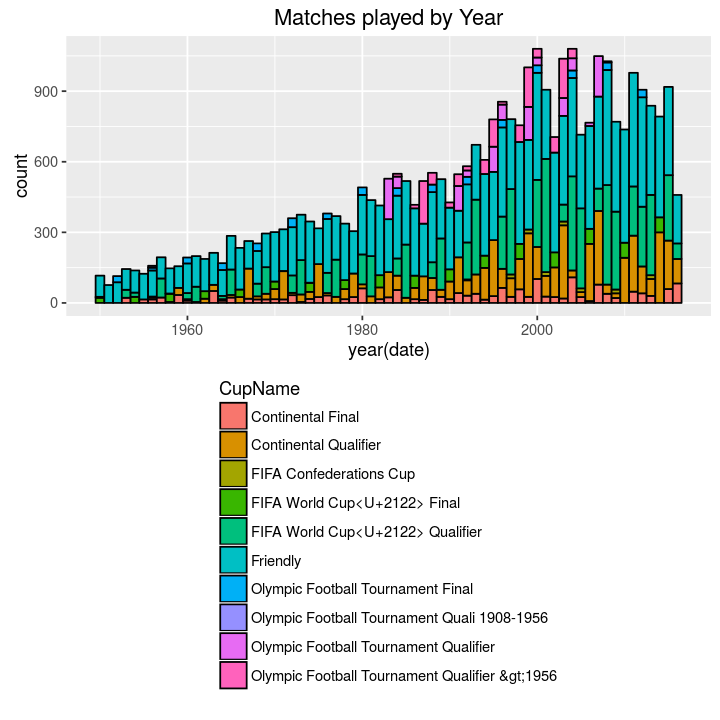

In [83]:
# how many international games have been played over the years?
matches %>%
  ggplot(mapping = aes(year(date))) +
    geom_bar(aes(fill=CupName), width=1, color="black") +
    theme(legend.position = "bottom", legend.direction = "vertical") + ggtitle("Matches played by Year")

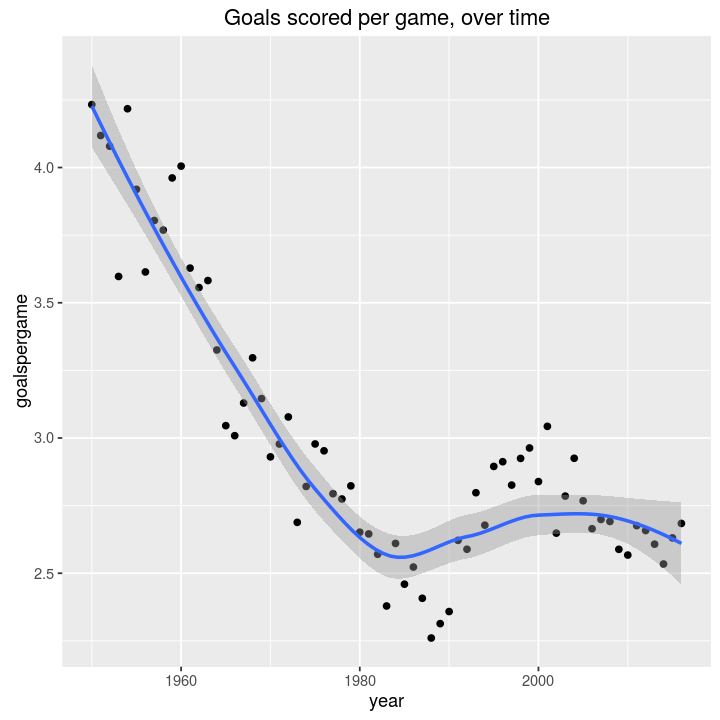

In [84]:
# how many goals have been scored per game over the years? 
matches %>%
  dplyr::group_by(year = year(date)) %>%
  dplyr::summarize(
    totalgames = n(),
    totalgoals = sum(team1Score + team2Score),
    goalspergame = totalgoals / totalgames
    ) %>%
  ggplot(mapping = aes(x = year, y = goalspergame)) +
    geom_point() +
    geom_smooth(method = "loess") + ggtitle("Goals scored per game, over time")

Warning message in if (class(obj) == "amelia") {:
"the condition has length > 1 and only the first element will be used"Warning message:
"Unknown column 'arguments'"Warning message:
"Unknown column 'arguments'"Warning message:
"Unknown column 'imputations'"

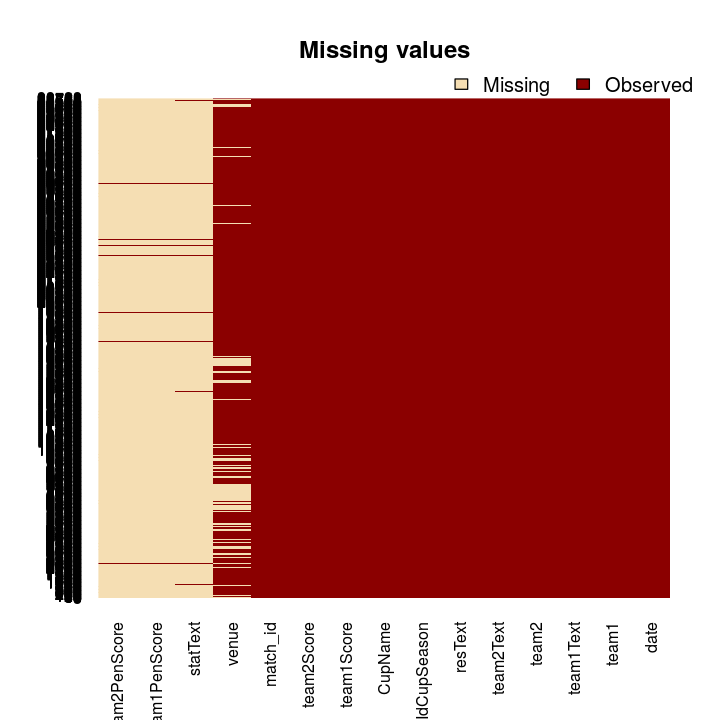

In [85]:
# what values is our dataset missing?
Amelia::missmap(matches, main = "Missing values")

A few things we can note from our graphs above, as well as from examining the dataset:

Although our sample size of matches played before 1960 is fairly small, we can note that the era of free-wheeling, mostly attacking football coming to an end with the perfection of devensive tactics like [catenaccio](https://en.wikipedia.org/wiki/Catenaccio) in Italy, and eventually with the era of [Total Football](https://en.wikipedia.org/wiki/Total_Football) which took off in the early '70s. We may need to factor in some of these developments into our model. 

`pen1Score` and `pen2Score` are only present whenever a match ended on penalties. All missing values indicate a match which did not get to a penalty shootout. Therefore, the values aren't really missing, so we can use these features if we want; however, the number of observations is fairly small, and penalty shoot-outs do have a reputation of being a lottery of sorts, especially at the highest level of play when the prize is advancement to a later stage of the World Cup. 

One additional thing to note is that, for matches ending on penalties, `team1Score` = `team2Score`; these values do *not* include the penalty shoot-out goals; still, those games weren't really draws, since they were decided on penalties. From a purely performance standpoint however, we might decide to consider a team losing on penalties as being closer to a draw than an actual loss.

`statText` is also only present for matches which *didn't* end in regulation time. It includes extra-time matches as well as penalty shoot-outs as above. Unlike `pen1Score` and `pen2Score` however, `team1Score` and `team2Score` do include all the goals scored in extra time as well. Same as before, we might decide that a team performed better if they lost in extra time vs. a loss in regulation; however, we will disregard this field for now. 

`venue` is interesting for the purpose of determining the home team, which in football has a distinct advantage (as we will later conclude). However, since `venue` is a text field, we will need to do some pattern matching with team names to determine the correct home team, which may present several problems. Also, about 15 percent of values are missing for this column, which will force us to consider these matches as being played in a neutral venue.

`CupName` can be useful to determine whether a game was a played as a friendly, a qualifier, or a final tournament. Simple pattern matching will be enough for this task.

`IdCupSeason` can be ignored at this time.

`resText` can be ignored as all the information is also contained in other non-text fields.

Finally, we may have an issue with the fact that `team1` consistently performs better than `team2` - likely because most of the games list the home team first:

In [86]:
summary(matches$team1Score - matches$team2Score)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-22.0000  -1.0000   1.0000   0.6135   2.0000  31.0000 

The `Mean` value for the goal differential is greater than 0.6, which may present a problem later on when training the model - it may capture this bias *`team1` is better than `team2`*, which is something we'd rather avoid, especially since the World Cup final tournament is played in a single country.

So let's get rid of that by simply randomizing the order in which teams are listed for any one match.

In [87]:
set.seed(4342)
matches$switch = runif(nrow(matches), min = 0, max = 1)

matches <- bind_rows(
  matches %>% dplyr::filter(switch < 0.5),
  matches %>% dplyr::filter(switch >= 0.5) %>%
    dplyr::mutate(
      x_team2 = team2,
      team2 = team1,
      team1 = x_team2,
      
      x_team2Text = team2Text,
      team2Text = team1Text,
      team1Text = x_team2Text,

      x_resText = "",
      
      x_team2Score = team2Score,
      team2Score = team1Score,
      team1Score = x_team2Score,
      
      x_team2PenScore = team2PenScore,
      team2PenScore = team1PenScore,
      team1PenScore = x_team2PenScore
    ) %>%
    dplyr::select(
      date, team1, team1Text, team2, team2Text, resText, statText, venue, IdCupSeason, CupName, team1Score, team2Score, team1PenScore, team2PenScore, match_id, switch
    )
    ) %>% 
  dplyr::arrange(date) %>%
  dplyr::select(-c(switch))

summary(matches$team1Score - matches$team2Score)

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-31.000000  -1.000000   0.000000  -0.009117   1.000000  18.000000 

Now, we can create some aditional features about the matches.

In [88]:
# is the game played in a neutral venue
matches$team1Home <- mapply(grepl, pattern=matches$team1Text, x=matches$venue, MoreArgs = list(fixed = TRUE, ignore.case = FALSE))
matches$team2Home <- mapply(grepl, pattern=matches$team2Text, x=matches$venue, MoreArgs = list(fixed = TRUE, ignore.case = FALSE))
matches$neutralVenue <- !(matches$team1Home | matches$team2Home)

# text-matching the venue is not 100% accurate.
# some games get TRUE for both team1 and team2 (ex. Congo DR vs Congo)
# in this case, team1 is at home
matches$team2Home[(matches$team1Home == TRUE) & (matches$team2Home == TRUE)] <- FALSE

# game type: Friendly, Qualifier, Final Tournament
matches$friendly <- FALSE
matches$friendly[matches$CupName == "Friendly"] <- TRUE

matches$qualifier <- FALSE
matches$qualifier[matches$CupName %like% "Qual"] <- TRUE

matches$finaltourn <- FALSE
matches$finaltourn[matches$CupName %like% "Final"] <- TRUE
matches$finaltourn[matches$CupName %like% "Confederations Cup"] <- TRUE

head(matches)

date,team1,team1Text,team2,team2Text,resText,statText,venue,IdCupSeason,CupName,...,team2Score,team1PenScore,team2PenScore,match_id,team1Home,team2Home,neutralVenue,friendly,qualifier,finaltourn
1950-02-17,GRE,Greece,EGY,Egypt,2-0,NA,"CAIRO - Cairo , Egypt",2000010101,Friendly,...,2,NA,NA,652,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE
1950-02-25,SLV,El Salvador,HAI,Haiti,1-0,NA,"GUATEMALA CITY - Guatemala City , Guatemala",2000010101,Friendly,...,0,NA,NA,653,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE
1950-02-26,SLV,El Salvador,CRC,Costa Rica,0-1,NA,"GUATEMALA CITY - Guatemala City , Guatemala",2000010101,Friendly,...,1,NA,NA,654,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE
1950-02-27,CUW,Curacao,CRC,Costa Rica,1-0,NA,"GUATEMALA CITY - Guatemala City , Guatemala",2000010101,Friendly,...,1,NA,NA,655,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE
1950-02-27,COL,Colombia,GUA,Guatemala,2-1,NA,"GUATEMALA CITY - Guatemala City , Guatemala",2000010101,Friendly,...,2,NA,NA,656,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE
1950-02-28,HAI,Haiti,NCA,Nicaragua,2-4,NA,"GUATEMALA CITY - Guatemala City , Guatemala",2000010101,Friendly,...,2,NA,NA,657,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE


At this point, we're going to eliminate friendly matches from the dataset.

This decision is based on the observation that, with few exceptions, the main objective for a team playing a friendly is not to win it, but to evaluate its own players and tactics.

For this reason it's not uncommon for friendlies to allow an unlimited number of substitutions, and for a team to roll out its entire squad during a friendly game.

If you'd like to experiment with keeping friendlies in the dataset, you can comment out the line below.

In [89]:
# only use official matches (no friendlies)
matches <- matches %>% dplyr::filter(friendly == FALSE)

Up until this point we've only looked at individual matches. However, what we really need is to look at each team's performance over its history. 

When we build our predictive model, we'd like to supply it with as many features about each of the teams about to be involved in a match. For that, we need to have a team-centric dataset with historical data.

Building this dataset is simple: take each observation in `matches` - which has the form *"team1 vs team2"* - and produce two separate observations of the form *"team1 played against team2"* and *"team2 played against team1"* respectively.

In [90]:
# transform the matches table into a team performance table, where each team being 
# involved in a game is a separate observation (row)

teamperf <- bind_rows(
    (matches %>%
    dplyr::mutate(
      name = team1,
      opponentName = team2,
      homeVenue = team1Home,
      neutralVenue = neutralVenue,
      gs = team1Score,
      ga = team2Score,
      gd = gs - ga,
      w = (team1Score > team2Score),
      l = (team1Score < team2Score),
      d = (team1Score == team2Score),
      friendly = friendly,
      qualifier = qualifier,
      finaltourn = finaltourn
    ) %>%
    dplyr::select (match_id, date, name, opponentName, homeVenue, neutralVenue, gs, ga, gd, w, l, d, friendly, qualifier, finaltourn))
    ,
    (matches %>%
    dplyr::mutate(
      name = team2,
      opponentName = team1,
      homeVenue = team2Home,
      neutralVenue = neutralVenue,
      gs = team2Score,
      ga = team1Score,
      gd = gs - ga,
      w = (team1Score < team2Score),
      l = (team1Score > team2Score),
      d = (team1Score == team2Score),
      friendly = friendly,
      qualifier = qualifier,
      finaltourn = finaltourn
    ) %>%
      dplyr::select (match_id, date, name, opponentName, homeVenue, neutralVenue, gs, ga, gd, w, l, d, friendly, qualifier, finaltourn))
  ) %>%
  dplyr::arrange(date)

head(teamperf)

match_id,date,name,opponentName,homeVenue,neutralVenue,gs,ga,gd,w,l,d,friendly,qualifier,finaltourn
29854,1950-03-08,WAL,NIR,TRUE,FALSE,0,0,0,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE
29854,1950-03-08,NIR,WAL,FALSE,FALSE,0,0,0,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE
29855,1950-04-02,ESP,POR,TRUE,FALSE,5,1,4,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE
29855,1950-04-02,POR,ESP,FALSE,FALSE,1,5,-4,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE
29856,1950-04-09,ESP,POR,FALSE,FALSE,2,2,0,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE
29856,1950-04-09,POR,ESP,TRUE,FALSE,2,2,0,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE


In order to capture some information about how good each team is, let's define a **winning percentage** formula:

`winpercentage = (wins + 0.5 * draws) / games played`

Then, let's plot that for each team which has played a significant number of games.

We're going to define the win percentage formula and plot as R functions, since we might want to re-use them after we further tweak our dataset.

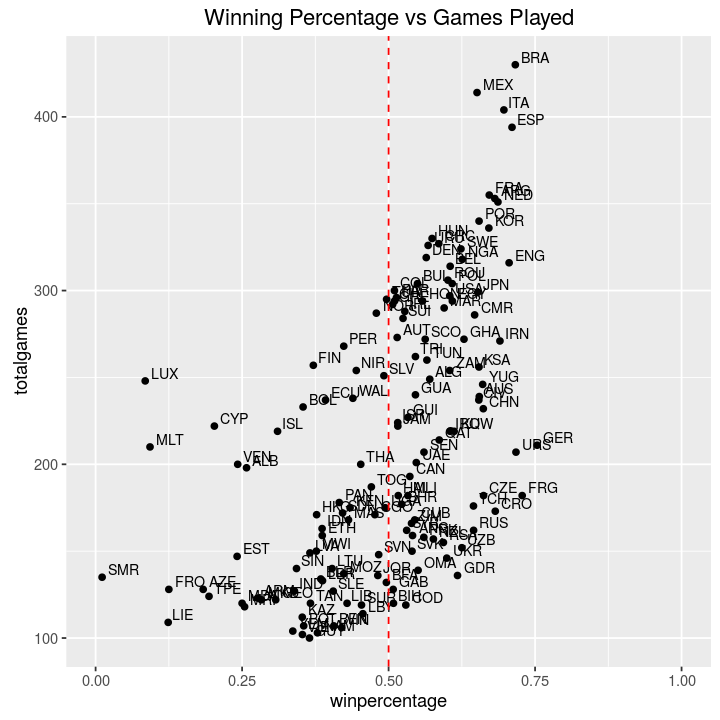

In [91]:
# Out of the teams who have played at least 100 games, what are the winning percentages for each of those teams?

formula_winpercentage <- function(totalgames, wins, draws) {
    return ((wins + 0.5 * draws) / totalgames)
}

plot_winpercentage <- function(teamperf, mingames) {
  teamperf %>%
  group_by(name) %>%
  summarize(
    totalgames = n(),
    wins = length(w[w==TRUE]),
    draws = length(d[d==TRUE]),
    winpercentage = formula_winpercentage(totalgames, wins, draws)
  ) %>%
  filter(totalgames >= mingames ) %>%
  ggplot(mapping = aes(x = winpercentage, y = totalgames)) +
  geom_point(size = 1.5) + 
  geom_text(aes(label=name), hjust=-.2 , vjust=-.2, size=3) +
  geom_vline(xintercept = .5, linetype = 2, color = "red") +
  ggtitle("Winning Percentage vs Games Played") +
  expand_limits(x = c(0,1))
} 

plot_winpercentage(teamperf, 100)

Straight away we can see that there are some potential issues with our dataset.

For one thing, some countries have ceased to exist, either because they dissolved into multiple countries - for example the Soviet Union (`URS`), Yugoslavia (`YUG`) or Czechoslovakia (`TCH`), or because they united into one country - like it was the case with the [German reunification](https://en.wikipedia.org/wiki/German_reunification) of 1990. In the latter case, West Germany (`FRG`) and East Germany (`GDR`) unified into a single Germany (`GER`). 

Another case was when a country would rename itself - for example from Zaire (`ZAI`) to Democratic Republic of the Congo (`COD`).

Here is a complete list of all the FIFA [obsolete country codes](https://en.wikipedia.org/wiki/List_of_FIFA_country_codes#Obsolete_country_codes) which stood for countries and territories that no longer exist.

From our perspective, for the purposes of continuity we would like to consider the new countries as successors to (part of) the old ones, because it will allow us to take past performance into account instead of starting from scratch. The process is not 100% straightforward - for example, which of the [six countries](https://en.wikipedia.org/wiki/Breakup_of_Yugoslavia) should we consider as a succesor to Yugoslavia? - but we will undergo a best effort approach. 

In [92]:
# transform old country codes into new ones.
countryCodeMappings <- matrix(c(
  "FRG","GER",
  "TCH","CZE",
  "URS","RUS",
  "SCG","SRB",
  "ZAI","COD"
  ), ncol=2, byrow = TRUE)

for (i in 1:nrow(countryCodeMappings)) {
  teamperf$name[teamperf$name == countryCodeMappings[i,1]] <- countryCodeMappings[i,2]
  teamperf$opponentName[teamperf$opponentName == countryCodeMappings[i,1]] <- countryCodeMappings[i,2]
  
  matches$team1[matches$team1 == countryCodeMappings[i,1]] <- countryCodeMappings[i,2]
  matches$team2[matches$team2 == countryCodeMappings[i,1]] <- countryCodeMappings[i,2]
}

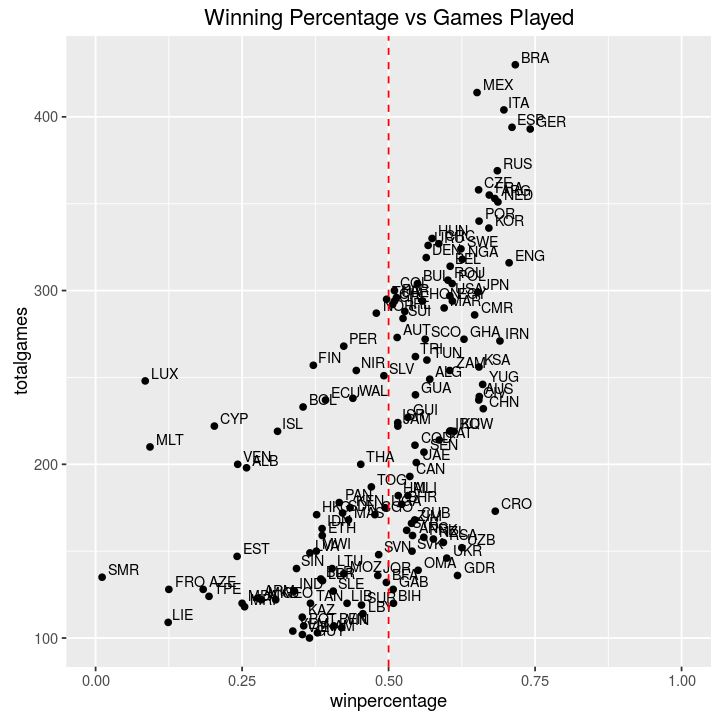

In [93]:
# let's run the win percentage graph again
plot_winpercentage(teamperf, 100)

Since our model will predict match results, it would be useful to also look at the distribution of match scores as well as total number of goals scored per game.

In [94]:
# what is the occurence frequency for match scores?

scorefreq <- matches %>%
  group_by(team1Score, team2Score) %>%
  summarise(
    n = n(),
    freq = n / nrow(matches)
  ) %>%
  ungroup() %>%
  mutate(
    scoretext = paste(team1Score,"-",team2Score)
  ) %>%
  arrange(desc(freq)) 

  head(scorefreq, 20)

team1Score,team2Score,n,freq,scoretext
1,1,1596,0.09401508,1 - 1
1,0,1511,0.08900801,1 - 0
0,1,1468,0.08647502,0 - 1
0,0,1384,0.08152686,0 - 0
2,0,1144,0.06738926,2 - 0
0,2,1127,0.06638784,0 - 2
2,1,1055,0.06214656,2 - 1
1,2,1052,0.06196984,1 - 2
0,3,705,0.04152922,0 - 3
3,0,637,0.03752356,3 - 0


gs,n,freq
2,3867,0.227792177
3,3449,0.203169180
1,2979,0.175483035
4,2307,0.135897738
5,1419,0.083588596
0,1384,0.081526861
6,729,0.042942978
7,416,0.024505184
8,204,0.012016965
9,96,0.005655042


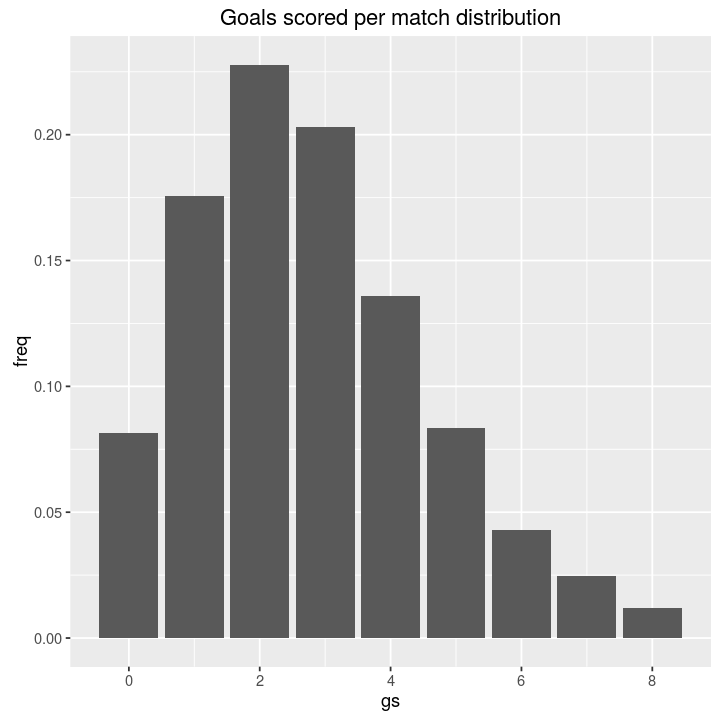

In [95]:
# distribution of goals scored per match
gsfreq <- matches %>%
  group_by(gs = team1Score + team2Score) %>%
  summarise(
    n = n(),
    freq = n / nrow(matches)
  ) %>%
  ungroup() %>%
  arrange(desc(freq)) 

head(gsfreq, 10)

gsfreq %>%
  filter(freq >= 0.01) %>%
  ggplot(mapping = aes(x = gs, y = freq)) + geom_bar(stat = "identity") + ggtitle("Goals scored per match distribution")

gd,n,freq
-4,476,0.02803959
-3,993,0.05849434
-2,1743,0.10267436
-1,2807,0.16535108
0,3629,0.21377238
1,2868,0.16894439
2,1776,0.10461828
3,932,0.05490104
4,500,0.02945335


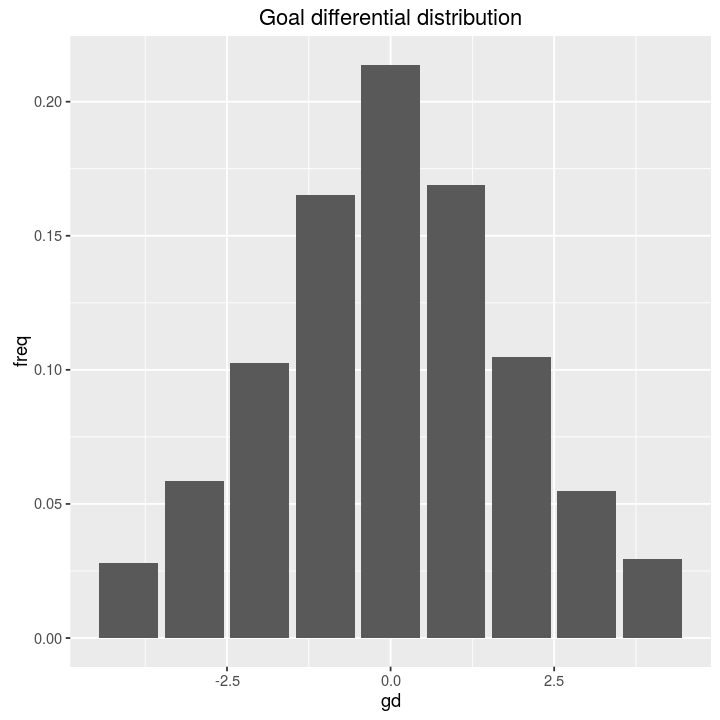

In [96]:
# distribution of goal differential
gdfreq <- matches %>%
  group_by(gd = team1Score - team2Score) %>%
  summarise(
    n = n(),
    freq = n / nrow(matches)
  ) %>%
  ungroup() %>%
  arrange(gd) 

head(gdfreq %>% filter(abs(gd)<=4), 10)

gdfreq %>%
  filter(abs(gd)<=4) %>%
  ggplot(mapping = aes(x = gd, y = freq)) + geom_bar(stat = "identity") + ggtitle("Goal differential distribution")

### Outliers ###

Since our aim is to predict the goal differential (win margin) between the two teams in a match, we'd like to get rid of *outliers* - values which are far away at the end of the spectrum of possible values for this variable. The reason is that outliers can drastically change the results of the data analysis and statistical modeling. Outliers increase the error variance, reduce the power of statistical tests, and ultimately they can bias or influence estimates.

So let's deal with all matches where **the goal differential is greater than 7**. 

First, let's verify how many of those we've got in the first place:

In [97]:
# how many outliers do we have?
temp <- matches %>% dplyr::filter(abs(team1Score - team2Score) > 7)
head(temp)
paste(nrow(temp), "matches, or", (nrow(temp)/nrow(matches)*100), "% of total.")

date,team1,team1Text,team2,team2Text,resText,statText,venue,IdCupSeason,CupName,...,team2Score,team1PenScore,team2PenScore,match_id,team1Home,team2Home,neutralVenue,friendly,qualifier,finaltourn
1950-07-02,BOL,Bolivia,URU,Uruguay,8-0,NA,NA,7,FIFA World Cup<U+2122> Final,...,8,NA,NA,31028,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE
1952-07-15,YUG,Yugoslavia,IND,India,10-1,NA,NA,197058,Olympic Football Tournament Final,...,1,NA,NA,401,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE
1952-07-16,USA,USA,ITA,Italy,8-0,NA,NA,197058,Olympic Football Tournament Final,...,8,NA,NA,405,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE
1953-07-19,MEX,Mexico,HAI,Haiti,8-0,NA,"Estadio Ol<U+00ED>mpico Universitario - Mexico City , Mexico",8,FIFA World Cup<U+2122> Qualifier,...,0,NA,NA,32262,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE
1953-09-26,AUT,Austria,POR,Portugal,9-1,NA,"VIENNA - Vienna , Austria",8,FIFA World Cup<U+2122> Qualifier,...,1,NA,NA,32269,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE
1953-12-17,LUX,Luxembourg,FRA,France,8-0,NA,"Parc des Princes - Paris , France",8,FIFA World Cup<U+2122> Qualifier,...,8,NA,NA,32288,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE


[1] "237 matches, or 1.39608859566447 % of total."

Not bad - only a very small percentage of games would be outliers as per our definition. 

> NOTE: As a rule of thumb, any value which is out of range of the 5th and 95th percentile may be considered an outlier.
 
Let's deal with the outliers in `teamperf` by capping the goal differential to the [-7, +7] interval:

In [98]:
# get rid of all the outliers by capping the gd to [-7, +7]
teamperf$gd[teamperf$gd < -7] <- -7
teamperf$gd[teamperf$gd > +7] <- +7

### Strength of opposition ###

We may also want to take into account the fact that teams play most of their matches against opponents from the same [FIFA Confederation](http://www.fifa.com/associations/index.html) - for example, European teams play mostly against other UEFA members, while African teams face other CAF members for the most part. Only during final tournaments like the Olympics, the World Cup and the Confederations Cup will teams play official (non-friendly) matches against non-confederation opponents. 

Since not all conferences are the same general strength, we can adjust our `teamperf` dataset to also include information about the conference the opponent belongs to. We can assign adjustment coefficients to each conference, in a similar way to how FIFA's World ranking algorithm [accounts for regional strength](https://en.wikipedia.org/wiki/FIFA_World_Rankings#Regional_strength).

In [99]:
# get information about the various FIFA confederations and the teams they contain
if(!file.exists("teams.csv")){
  tryCatch(download.file('https://raw.githubusercontent.com/neaorin/PredictTheWorldCup/master/input/teams.csv'
                         ,destfile="./teams.csv",method="auto"))
}

if(file.exists("teams.csv")) teams <- read_csv("teams.csv")

# confederations and adjustment coefficients for them
confederations <- as.data.frame(matrix(c(
  "UEFA","0.99",
  "CONMEBOL","1.00",
  "CONCACAF","0.85",
  "AFC","0.85",
  "CAF","0.85",
  "OFC","0.85"
), ncol=2, byrow = TRUE, dimnames = list(NULL, c("confederation","adjust"))), stringsAsFactors = FALSE)

confederations$confederation <- as.vector(confederations$confederation)
confederations$adjust <- as.numeric(confederations$adjust)

# add a confederation coefficient for the opponent faced 
teamperf <- teamperf %>%
  dplyr::left_join(teams, by=c("opponentName" = "fifa_code")) %>%
  dplyr::left_join(confederations, by=c("confederation")) %>%
  dplyr::mutate(
    opponentConfederationCoefficient = adjust
  ) %>%
dplyr::select(match_id, date, name = name.x, opponentName, opponentConfederationCoefficient,  homeVenue, neutralVenue, gs, ga, gd, w, l, d, friendly, qualifier, finaltourn)

# set missing values to 1
teamperf$opponentConfederationCoefficient[is.na(teamperf$opponentConfederationCoefficient)] <- 1


Parsed with column specification:
cols(
  confederation = col_character(),
  name = col_character(),
  fifa_code = col_character(),
  ioc_code = col_character()
)


## Feature Engineering ##

Now, let's calculate some lag features for each team which is about to play a game.

We'll look at the previous `N` games a team has played, up to the game in question, and we'll calculate the percentage of wins, draws, losses, as well as the goal differential, per game, for those past `N` games.

For example, taking `N=10`:

```
last10games_w_per = (number of wins in the past 10 games) / 10
last10games_d_per = (number of draws in the past 10 games) / 10
last10games_l_per = (number of losses in the past 10 games) / 10
last10games_gd_per = (goals scored - goals conceeded in the past 10 games) / 10 
```

We'll use three different values for `N` (10, 30 and 50) to capture short-, medium-, and long-term form.

We'll calculate those values for every team and every game in our dataset.

To model the strength of opposition faced, we'll use the same technique with respect to the `opponentConfederationCoefficient` values we introduced earlier.

In [100]:
# Let's calculate some lag features for each team which is about to play a game
# we'll take three windows: last 5 games, last 20 games, last 35 games.
# for each window we'll calculate some values

lagfn <- function(data, width) {
  return (rollapplyr(data, width = width + 1, FUN = sum, fill = NA, partial=TRUE) - data)
}

lagfn_per <- function(data, width) {
  return (lagfn(data, width) / width)
}

team_features <- teamperf %>%
  dplyr::arrange(name, date) %>%
  dplyr::group_by(name) %>%
  dplyr::mutate(
    last10games_w_per = lagfn_per(w, 10),
    last30games_w_per = lagfn_per(w, 30),
    last50games_w_per = lagfn_per(w, 50),

    last10games_l_per = lagfn_per(l, 10),
    last30games_l_per = lagfn_per(l, 30),
    last50games_l_per = lagfn_per(l, 50),

    last10games_d_per = lagfn_per(d, 10),
    last30games_d_per = lagfn_per(d, 30),
    last50games_d_per = lagfn_per(d, 50),
            
    last10games_gd_per = lagfn_per(gd, 10),
    last30games_gd_per = lagfn_per(gd, 30),
    last50games_gd_per = lagfn_per(gd, 50),
      
    last10games_opp_cc_per = lagfn_per(opponentConfederationCoefficient, 10),
    last30games_opp_cc_per = lagfn_per(opponentConfederationCoefficient, 30),
    last50games_opp_cc_per = lagfn_per(opponentConfederationCoefficient, 50)

  ) %>%
  dplyr::select (
    match_id, date, name, opponentName, gs, ga,
    w, last10games_w_per, last30games_w_per, last50games_w_per,
    l, last10games_l_per, last30games_l_per, last50games_l_per,
    d, last10games_d_per, last30games_d_per, last50games_d_per,
    gd, last10games_gd_per, last30games_gd_per, last50games_gd_per,
    opponentConfederationCoefficient, last10games_opp_cc_per, last30games_opp_cc_per, last50games_opp_cc_per

          ) %>%
  dplyr::ungroup()

head((team_features %>% dplyr::filter(name == "BRA" & date >= '1970-01-01')), n = 20)
summary(team_features)

match_id,date,name,opponentName,gs,ga,w,last10games_w_per,last30games_w_per,last50games_w_per,...,last30games_d_per,last50games_d_per,gd,last10games_gd_per,last30games_gd_per,last50games_gd_per,opponentConfederationCoefficient,last10games_opp_cc_per,last30games_opp_cc_per,last50games_opp_cc_per
24496,1970-06-03,BRA,CZE,4,1,TRUE,0.6,0.5333333,0.58,...,0.1666667,0.18,3,1.8,0.8333333,0.90,0.99,0.968,0.9716667,0.9818
24504,1970-06-07,BRA,ENG,1,0,TRUE,0.7,0.5666667,0.60,...,0.1666667,0.18,1,2.3,1.0333333,0.98,0.99,0.968,0.9713333,0.9816
24508,1970-06-10,BRA,ROU,3,2,TRUE,0.8,0.5666667,0.60,...,0.1666667,0.18,1,2.5,1.0333333,0.98,0.99,0.968,0.9710000,0.9814
24516,1970-06-14,BRA,PER,4,2,TRUE,0.9,0.6000000,0.62,...,0.1666667,0.18,2,2.6,1.1333333,1.06,1.00,0.982,0.9710000,0.9812
24518,1970-06-17,BRA,URU,3,1,TRUE,1.0,0.6000000,0.64,...,0.1666667,0.16,2,2.8,1.1333333,1.10,1.00,0.997,0.9760000,0.9812
24521,1970-06-21,BRA,ITA,4,1,TRUE,1.0,0.6333333,0.64,...,0.1333333,0.16,3,2.8,1.2000000,1.12,0.99,0.997,0.9763333,0.9812
523,1972-08-27,BRA,DEN,2,3,FALSE,1.0,0.6333333,0.64,...,0.1333333,0.16,-1,2.6,1.2666667,1.12,0.99,0.996,0.9763333,0.9812
532,1972-08-29,BRA,HUN,2,2,FALSE,0.9,0.6000000,0.64,...,0.1333333,0.14,0,2.2,1.1666667,1.10,0.99,0.995,0.9763333,0.9812
539,1972-08-31,BRA,IRN,0,1,FALSE,0.8,0.5666667,0.62,...,0.1666667,0.16,-1,1.8,1.1000000,1.06,0.85,0.994,0.9760000,0.9812
28750,1974-06-13,BRA,YUG,0,0,FALSE,0.7,0.5333333,0.60,...,0.1666667,0.16,0,1.1,1.0000000,1.02,1.00,0.979,0.9713333,0.9784


    match_id          date                         name          
 Min.   :    1   Min.   :1950-03-08 00:00:00   Length:34191      
 1st Qu.:21053   1st Qu.:1987-02-08 00:00:00   Class :character  
 Median :25312   Median :1999-04-11 00:00:00   Mode  :character  
 Mean   :24655   Mean   :1995-09-21 11:36:48                     
 3rd Qu.:29544   3rd Qu.:2007-04-18 00:00:00                     
 Max.   :33783   Max.   :2016-07-10 00:00:00                     
 opponentName             gs              ga            w          
 Length:34191       Min.   : 0.00   Min.   : 0.00   Mode :logical  
 Class :character   1st Qu.: 0.00   1st Qu.: 0.00   FALSE:20785    
 Mode  :character   Median : 1.00   Median : 1.00   TRUE :13406    
                    Mean   : 1.43   Mean   : 1.44   NA's :0        
                    3rd Qu.: 2.00   3rd Qu.: 2.00                  
                    Max.   :31.00   Max.   :31.00                  
 last10games_w_per last30games_w_per last50games_w_per     l  

Now that we have built a series of team-specific features, we need to fold them back into match-specific features.

We will then have a set of features for both teams about to face each other.

In [101]:
# fold per-team features into per-match features
match_features <- matches %>%
  left_join(team_features, by=c("match_id", "team1" = "name")) %>%
  left_join(team_features, by=c("match_id", "team2" = "name"), suffix=c(".t1",".t2")) %>%
  dplyr::select(
    date, match_id, team1, team2, team1Home, team2Home, neutralVenue, team1Score, team2Score, friendly, qualifier, finaltourn,
    last10games_w_per.t1,
    last30games_w_per.t1,
    last50games_w_per.t1,
    last10games_l_per.t1,
    last30games_l_per.t1,
    last50games_l_per.t1,
    last10games_d_per.t1,
    last30games_d_per.t1,
    last50games_d_per.t1,
    last10games_gd_per.t1, 
    last30games_gd_per.t1,
    last50games_gd_per.t1,
    last10games_opp_cc_per.t1, 
    last30games_opp_cc_per.t1, 
    last50games_opp_cc_per.t1,
    last10games_w_per.t2,
    last30games_w_per.t2,
    last50games_w_per.t2,
    last10games_l_per.t2,
    last30games_l_per.t2,
    last50games_l_per.t2,
    last10games_d_per.t2,
    last30games_d_per.t2,
    last50games_d_per.t2,
    last10games_gd_per.t2, 
    last30games_gd_per.t2,
    last50games_gd_per.t2,
    last10games_opp_cc_per.t2, 
    last30games_opp_cc_per.t2, 
    last50games_opp_cc_per.t2,
    outcome = gd.t1
  )

head(match_features)
names(match_features)

date,match_id,team1,team2,team1Home,team2Home,neutralVenue,team1Score,team2Score,friendly,...,last10games_d_per.t2,last30games_d_per.t2,last50games_d_per.t2,last10games_gd_per.t2,last30games_gd_per.t2,last50games_gd_per.t2,last10games_opp_cc_per.t2,last30games_opp_cc_per.t2,last50games_opp_cc_per.t2,outcome
1950-03-08,29854,WAL,NIR,TRUE,FALSE,FALSE,0,0,FALSE,...,0,0,0,0.0,0.0000000,0.00,0.000,0.000,0.0000,0
1950-04-02,29855,ESP,POR,TRUE,FALSE,FALSE,5,1,FALSE,...,0,0,0,0.0,0.0000000,0.00,0.000,0.000,0.0000,4
1950-04-09,29856,ESP,POR,FALSE,TRUE,FALSE,2,2,FALSE,...,0,0,0,-0.4,-0.1333333,-0.08,0.099,0.033,0.0198,0
1950-04-15,29857,ENG,SCO,FALSE,TRUE,FALSE,1,0,FALSE,...,0,0,0,0.0,0.0000000,0.00,0.000,0.000,0.0000,1
1950-06-24,31013,BRA,MEX,FALSE,FALSE,TRUE,4,0,FALSE,...,0,0,0,0.0,0.0000000,0.00,0.000,0.000,0.0000,4
1950-06-25,31015,ENG,CHI,FALSE,FALSE,TRUE,2,0,FALSE,...,0,0,0,0.0,0.0000000,0.00,0.000,0.000,0.0000,2


[1] "date"                      "match_id"                 
 [3] "team1"                     "team2"                    
 [5] "team1Home"                 "team2Home"                
 [7] "neutralVenue"              "team1Score"               
 [9] "team2Score"                "friendly"                 
[11] "qualifier"                 "finaltourn"               
[13] "last10games_w_per.t1"      "last30games_w_per.t1"     
[15] "last50games_w_per.t1"      "last10games_l_per.t1"     
[17] "last30games_l_per.t1"      "last50games_l_per.t1"     
[19] "last10games_d_per.t1"      "last30games_d_per.t1"     
[21] "last50games_d_per.t1"      "last10games_gd_per.t1"    
[23] "last30games_gd_per.t1"     "last50games_gd_per.t1"    
[25] "last10games_opp_cc_per.t1" "last30games_opp_cc_per.t1"
[27] "last50games_opp_cc_per.t1" "last10games_w_per.t2"     
[29] "last30games_w_per.t2"      "last50games_w_per.t2"     
[31] "last10games_l_per.t2"      "last30games_l_per.t2"     
[33] "last50games_l_per.t2"      "last10games_d_per.t2"     
[35] "last30games_d_per.t2"      "last50games_d_per.t2"     
[37] "last10games_gd_per.t2"     "last30games_gd_per.t2"    
[39] "last50games_gd_per.t2"     "last10games_opp_cc_per.t2"
[41] "last30games_opp_cc_per.t2" "last50games_opp_cc_per.t2"
[43] "outcome"

We're also going to get rid of some columns which should not be used in training - specifically `team1Score` and `team2Score`. We will use the new `outcome` column instead - which is the difference between `team1Score` and `team2Score`.

In [102]:
# drop all non-interesting columns, and those which should not be supplied for new data (like scores)
match_features <- match_features %>%
  dplyr::select(-c(match_id,team1Score,team2Score))

head(match_features)
names(match_features)

date,team1,team2,team1Home,team2Home,neutralVenue,friendly,qualifier,finaltourn,last10games_w_per.t1,...,last10games_d_per.t2,last30games_d_per.t2,last50games_d_per.t2,last10games_gd_per.t2,last30games_gd_per.t2,last50games_gd_per.t2,last10games_opp_cc_per.t2,last30games_opp_cc_per.t2,last50games_opp_cc_per.t2,outcome
1950-03-08,WAL,NIR,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,0.0,...,0,0,0,0.0,0.0000000,0.00,0.000,0.000,0.0000,0
1950-04-02,ESP,POR,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,0.0,...,0,0,0,0.0,0.0000000,0.00,0.000,0.000,0.0000,4
1950-04-09,ESP,POR,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,0.1,...,0,0,0,-0.4,-0.1333333,-0.08,0.099,0.033,0.0198,0
1950-04-15,ENG,SCO,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,0.0,...,0,0,0,0.0,0.0000000,0.00,0.000,0.000,0.0000,1
1950-06-24,BRA,MEX,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE,0.0,...,0,0,0,0.0,0.0000000,0.00,0.000,0.000,0.0000,4
1950-06-25,ENG,CHI,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE,0.1,...,0,0,0,0.0,0.0000000,0.00,0.000,0.000,0.0000,2


[1] "date"                      "team1"                    
 [3] "team2"                     "team1Home"                
 [5] "team2Home"                 "neutralVenue"             
 [7] "friendly"                  "qualifier"                
 [9] "finaltourn"                "last10games_w_per.t1"     
[11] "last30games_w_per.t1"      "last50games_w_per.t1"     
[13] "last10games_l_per.t1"      "last30games_l_per.t1"     
[15] "last50games_l_per.t1"      "last10games_d_per.t1"     
[17] "last30games_d_per.t1"      "last50games_d_per.t1"     
[19] "last10games_gd_per.t1"     "last30games_gd_per.t1"    
[21] "last50games_gd_per.t1"     "last10games_opp_cc_per.t1"
[23] "last30games_opp_cc_per.t1" "last50games_opp_cc_per.t1"
[25] "last10games_w_per.t2"      "last30games_w_per.t2"     
[27] "last50games_w_per.t2"      "last10games_l_per.t2"     
[29] "last30games_l_per.t2"      "last50games_l_per.t2"     
[31] "last10games_d_per.t2"      "last30games_d_per.t2"     
[33] "last50games_d_per.t2"      "last10games_gd_per.t2"    
[35] "last30games_gd_per.t2"     "last50games_gd_per.t2"    
[37] "last10games_opp_cc_per.t2" "last30games_opp_cc_per.t2"
[39] "last50games_opp_cc_per.t2" "outcome"

Let's also have a look at how correlated our numeric features are:

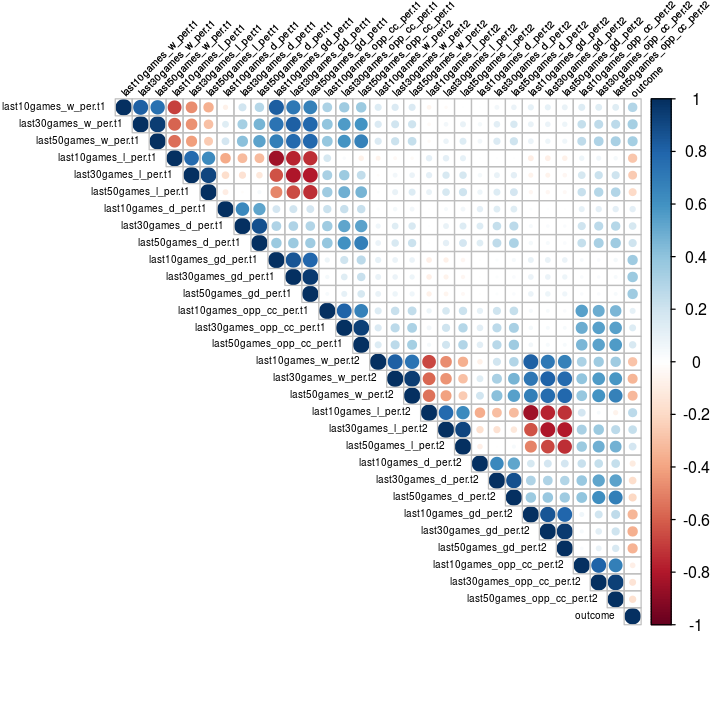

In [136]:
# correlation matrix
cormatrix <- cor(match_features %>% dplyr::select(-c(date, team1, team2, team1Home, team2Home, neutralVenue, friendly, qualifier, finaltourn)) )
corrplot(cormatrix, type = "upper", order = "original", tl.col = "black", tl.srt = 45, tl.cex = 0.5)

Well, we don't have a lot of surprises here. It looks like goal differential lag values are strongly correlated with win and loss lag values (as expected).

Also, we have strong positive correlations between lag features measuring the same metric on different lag windows. For example, `last10games_w_per.t1`, `last30games_w_per.t1` and `last50games_w_per.t1` are correlated. Also unsurprisingly, the correlation between 10- and 50- window metrics are weaker than between 10- and 30-, or 30- and 50-. But it does seem to suggest that good teams generally keep being good over time, and bad teams keep being bad. 

Last, none of our features has a correlation value (positive or negative) with our `outcome` that's much stronger than others. 

## Training our first model ##

The next step is to create a training formula for our model - it is going to describe the features we want to use and the outcome we're trying to predict. 

In [104]:
# create the training formula 
trainformula <- as.formula(paste('outcome',
                                 paste(names(match_features %>% dplyr::select(-c(date,team1,team2,outcome))),collapse=' + '),
                                 sep=' ~ '))
trainformula

outcome ~ team1Home + team2Home + neutralVenue + friendly + qualifier + 
    finaltourn + last10games_w_per.t1 + last30games_w_per.t1 + 
    last50games_w_per.t1 + last10games_l_per.t1 + last30games_l_per.t1 + 
    last50games_l_per.t1 + last10games_d_per.t1 + last30games_d_per.t1 + 
    last50games_d_per.t1 + last10games_gd_per.t1 + last30games_gd_per.t1 + 
    last50games_gd_per.t1 + last10games_opp_cc_per.t1 + last30games_opp_cc_per.t1 + 
    last50games_opp_cc_per.t1 + last10games_w_per.t2 + last30games_w_per.t2 + 
    last50games_w_per.t2 + last10games_l_per.t2 + last30games_l_per.t2 + 
    last50games_l_per.t2 + last10games_d_per.t2 + last30games_d_per.t2 + 
    last50games_d_per.t2 + last10games_gd_per.t2 + last30games_gd_per.t2 + 
    last50games_gd_per.t2 + last10games_opp_cc_per.t2 + last30games_opp_cc_per.t2 + 
    last50games_opp_cc_per.t2

We're going to split our `match_features` into a training and a testing dataset. We're going to be using the training data to fit our model, then we're going to use the testing data to evaluate its accuracy.

We're going to use the matches from 1960 - 2009 to train our model, and the matches from 2010 - present to validate it.

> NOTE: Although we're going to skip this step for the tutorial, [model cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) is an important step to verify how a model will respond to a new, unknown data set. We would be creating multiple "folds" of training and testing set combinations from our original data set, and validate each combination to obtain a more complete picture of our model's predictive power.

In [105]:
# training and testing datasets

data.train1 <- match_features %>% dplyr::filter(date < '2009/1/1')
data.test1 <- match_features %>% dplyr::filter(date >= '2009/1/1' & date <= '2015/1/1')

nrow(data.train1)
nrow(data.test1)

[1] 13979

[1] 2432

Now it's time to train our model. 

Since we're going to train a model to predict a numeric value (goal differential), we have a [wide choice of regression algorithms](https://docs.microsoft.com/en-us/azure/machine-learning/machine-learning-algorithm-cheat-sheet) we could use:

- linear regression
- neural network regression
- decision forest regression
- boosted decision tree regression
- etc.

Indeed we might decide to try several algorithms, with a variety of parameter combinations for each of them, in order to find the optimal model and training strategy. 

For this tutorial we're going to use a [random forest](https://cran.r-project.org/web/packages/randomForest/index.html), an algorithm which grows multiple [decision trees](https://en.wikipedia.org/wiki/Decision_tree_learning) from the features presented to it, and has each individual tree "vote" on the outcome for each new input vector (or in other words, new match to predict). It's fast, fairly accurate, and it gives an unbiased estimate of the generalization error, which makes cross-validation unnecessary for this particular algorithm.

The R implementation of the random forest algorithm is available in the [randomForest](https://cran.r-project.org/web/packages/randomForest/index.html) package.

We're going to tell the algorithm to grow 500 trees. 

> NOTE: The training process should take several minutes.

In [106]:
# train a random forest
model.randomForest1 <- randomForest::randomForest(trainformula, data = data.train1, 
                                                  importance = TRUE, ntree = 500)

summary(model.randomForest1)

                Length Class  Mode     
call                5  -none- call     
type                1  -none- character
predicted       13979  -none- numeric  
mse               500  -none- numeric  
rsq               500  -none- numeric  
oob.times       13979  -none- numeric  
importance         72  -none- numeric  
importanceSD       36  -none- numeric  
localImportance     0  -none- NULL     
proximity           0  -none- NULL     
ntree               1  -none- numeric  
mtry                1  -none- numeric  
forest             11  -none- list     
coefs               0  -none- NULL     
y               13979  -none- numeric  
test                0  -none- NULL     
inbag               0  -none- NULL     
terms               3  terms  call     

## Model Evaluation ##

In order to understand the importance of our predictors to the predicted `outcome`, we can use some built-in functions from the `randomForest` package:

,%IncMSE
team1Home,53.80586
team2Home,55.77554
neutralVenue,24.17729
friendly,0.00000
qualifier,12.17452
finaltourn,12.55640
last10games_w_per.t1,25.92746
last30games_w_per.t1,29.71390
last50games_w_per.t1,33.65757
last10games_l_per.t1,27.33055


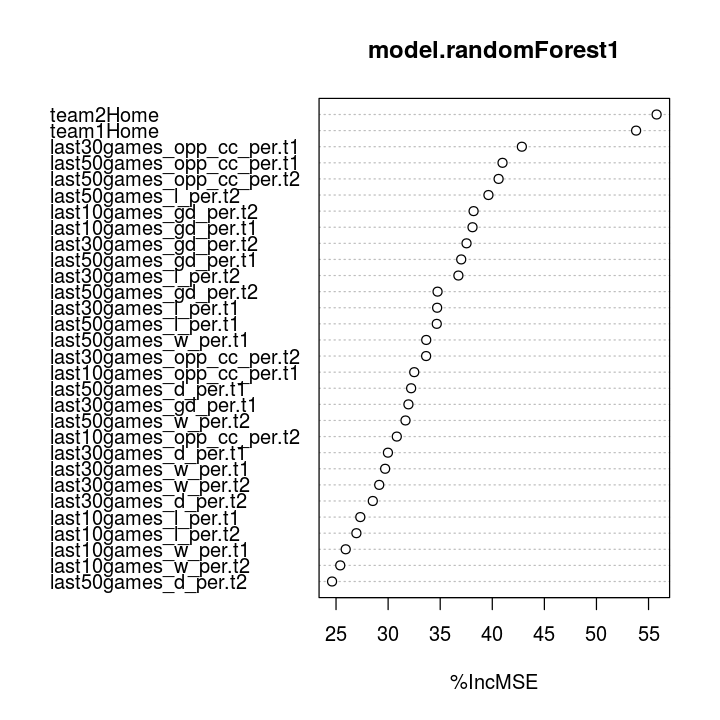

In [107]:
randomForest::importance(model.randomForest1, type=1)
randomForest::varImpPlot(model.randomForest1, type=1)

We can now expose our trained model to the test dataset, and calculate indicators related to its accuracy.

[1] "Mean Absolute Error: 1.3004170504386"

[1] "Root Mean Square Error: 1.7083426353785"

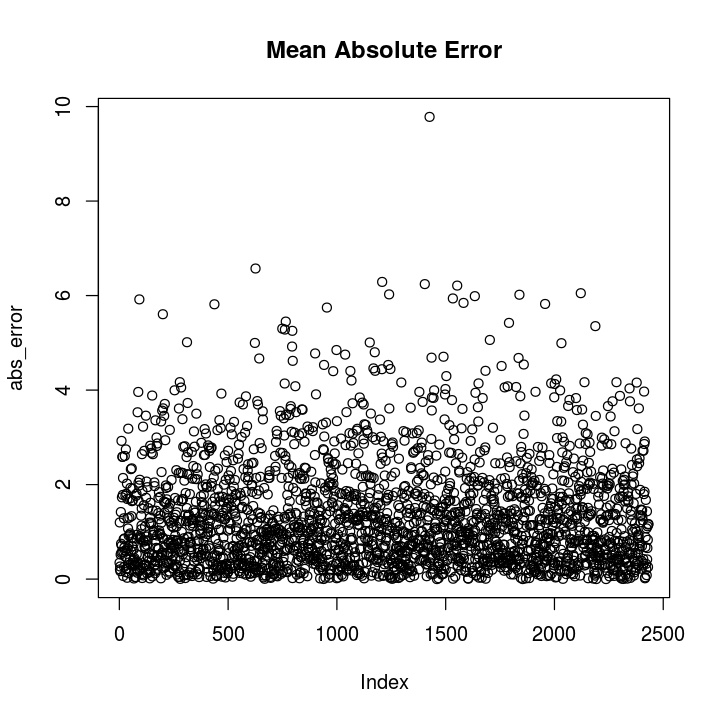

In [138]:
data.pred.randomForest1 <- predict(model.randomForest1, data.test1, predict.all = TRUE)

metrics.randomForest1.mae <- Metrics::mae(data.test1$outcome, data.pred.randomForest1$aggregate)
metrics.randomForest1.rmse <- Metrics::rmse(data.test1$outcome, data.pred.randomForest1$aggregate)

paste("Mean Absolute Error:", metrics.randomForest1.mae)
paste("Root Mean Square Error:",metrics.randomForest1.rmse)

abs_error <- abs(data.test1$outcome - data.pred.randomForest1$aggregate)
plot(abs_error, main="Mean Absolute Error") 

In [109]:
#check the largest MAE error
crazy_error <- which(abs_error > 8)
data.test1[crazy_error,]
data.pred.randomForest1$aggregate[crazy_error]

date,team1,team2,team1Home,team2Home,neutralVenue,friendly,qualifier,finaltourn,last10games_w_per.t1,...,last10games_d_per.t2,last30games_d_per.t2,last50games_d_per.t2,last10games_gd_per.t2,last30games_gd_per.t2,last50games_gd_per.t2,last10games_opp_cc_per.t2,last30games_opp_cc_per.t2,last50games_opp_cc_per.t2,outcome
2012-09-09,MSR,VGB,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,0,...,0.2,0.2,0.12,-2.8,-1.9,-1.24,0.85,0.85,0.527,7


1426 
-2.781433

## Simulating the Tournament ##

With a trained model at our disposal, we can now run tournament simulations on it. 

For example, let's take the [qualified teams](https://en.wikipedia.org/wiki/2018_FIFA_World_Cup#Qualified_teams) for the FIFA 2018 World Cup.

In [110]:
if(!file.exists("wc2018qualified.csv")){
    tryCatch(download.file('https://raw.githubusercontent.com/neaorin/PredictTheWorldCup/master/src/TournamentSim/wc2018qualified.csv'
                           ,destfile="./wc2018qualified.csv",method="auto"))
}
                
if(file.exists("wc2018qualified.csv")) qualified <- read_csv("wc2018qualified.csv")

Parsed with column specification:
cols(
  name = col_character(),
  draw = col_character()
)


We can now run the entire tournament 10,000 times, calling into the model to get a prediction for each match.

For performance reasons, we could generate **all the the possible two-team combinations**, then ask the model for predictions for each combination, and then store those predictions. 

We can store the mean values, as well as the standard deviation of the predicted values from every one of our decision trees. This will allow us to simulate a more realistic distribution of results, for multiple iterations of the same match.

In [111]:
# get a list of possible matches to be played at the world cup

data.topredict <- expand.grid(team1 = qualified$name, team2 = qualified$name, stringsAsFactors = FALSE) %>% filter(team1 < team2)

temp <- teamperf %>%
  semi_join(qualified, by = c("name")) %>%
  group_by(name) %>%
  summarise(
    date = max(date)
  )

temp <- team_features %>%
  semi_join(temp, by = c("name", "date"))

# calculate the features for every possbile match

data.topredict <- data.topredict %>%
  left_join(temp, by = c("team1" = "name")) %>%
  left_join(temp, by = c("team2" = "name"), suffix = c(".t1", ".t2")) %>%
  dplyr::select(
    team1, team2,
    last10games_w_per.t1,
    last30games_w_per.t1,
    last50games_w_per.t1,
    last10games_l_per.t1,
    last30games_l_per.t1,
    last50games_l_per.t1,
    last10games_d_per.t1,
    last30games_d_per.t1,
    last50games_d_per.t1,
    last10games_gd_per.t1, 
    last30games_gd_per.t1,
    last50games_gd_per.t1,
    last10games_opp_cc_per.t1, 
    last30games_opp_cc_per.t1, 
    last50games_opp_cc_per.t1,
    last10games_w_per.t2,
    last30games_w_per.t2,
    last50games_w_per.t2,
    last10games_l_per.t2,
    last30games_l_per.t2,
    last50games_l_per.t2,
    last10games_d_per.t2,
    last30games_d_per.t2,
    last50games_d_per.t2,
    last10games_gd_per.t2, 
    last30games_gd_per.t2,
    last50games_gd_per.t2,
    last10games_opp_cc_per.t2, 
    last30games_opp_cc_per.t2, 
    last50games_opp_cc_per.t2      
  ) %>%
  mutate(
    date = as.POSIXct("2018-06-14"), 
    team1Home = (team1 == "RUS"), team2Home = (team2 == "RUS"), neutralVenue = !(team1Home | team2Home), 
    friendly = FALSE, qualifier = FALSE, finaltourn = TRUE
  )

head(data.topredict)

team1,team2,last10games_w_per.t1,last30games_w_per.t1,last50games_w_per.t1,last10games_l_per.t1,last30games_l_per.t1,last50games_l_per.t1,last10games_d_per.t1,last30games_d_per.t1,...,last10games_opp_cc_per.t2,last30games_opp_cc_per.t2,last50games_opp_cc_per.t2,date,team1Home,team2Home,neutralVenue,friendly,qualifier,finaltourn
KSA,RUS,0.8,0.5000000,0.54,0.0,0.2000000,0.18,0.2,0.3000000,...,0.99,0.9806667,0.9844,2018-06-14,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE
EGY,RUS,0.5,0.4666667,0.54,0.4,0.4000000,0.34,0.1,0.1333333,...,0.99,0.9806667,0.9844,2018-06-14,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE
POR,RUS,0.6,0.6000000,0.60,0.0,0.1000000,0.14,0.4,0.3000000,...,0.99,0.9806667,0.9844,2018-06-14,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE
ESP,RUS,0.9,0.7333333,0.74,0.1,0.1666667,0.14,0.0,0.1000000,...,0.99,0.9806667,0.9844,2018-06-14,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE
MAR,RUS,0.7,0.4000000,0.50,0.2,0.2666667,0.22,0.1,0.3333333,...,0.99,0.9806667,0.9844,2018-06-14,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE
IRN,RUS,0.5,0.6000000,0.54,0.2,0.1333333,0.12,0.3,0.2666667,...,0.99,0.9806667,0.9844,2018-06-14,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE


At this point, our `data.topredict` table contains all the possible two-team match combinations, with calculated features for each team. 

We can now ask our model to predict outcomes for these matches:

In [112]:
# ask the model to predict our world cup matches
data.predicted <- predict(model.randomForest1, data.topredict, predict.all = TRUE)

head(data.predicted$individual)
head(data.predicted$aggregate)

1,-3,-2,2,-3.000000e+00,1.4000000,2.750000e+00,-1.00,2.00,1.000000e+00,-2.00,...,2.500000e-01,-1.000000e+00,-3.0000000,-1.00,-2.333333,-2.00,-2.00,-3.0000000,1.000000e+00,1.0000000
2,-2,0,1,0.000000e+00,-2.0000000,-1.000000e+00,-0.75,0.25,1.750000e+00,-3.25,...,-1.000000e+00,-3.600000e+00,-3.0000000,0.00,-1.200000,-1.40,-1.80,-3.0000000,5.000000e-01,-3.0000000
3,-2,0,2,2.168404e-19,-2.2000000,-2.000000e+00,1.50,2.00,2.168404e-19,2.00,...,2.168404e-19,-3.000000e+00,0.3333333,-1.00,-5.000000,-2.00,0.00,-2.0000000,0.000000e+00,-0.3333333
4,-1,-1,-1,2.168404e-19,1.6000000,-4.000000e+00,1.00,1.40,1.750000e+00,-0.75,...,1.000000e+00,2.168404e-19,2.0000000,-1.00,1.000000,0.25,-1.00,0.3333333,2.168404e-19,-0.3333333
5,-2,-7,2,-2.200000e+00,0.6666667,-3.200000e+00,0.00,-1.00,0.000000e+00,-1.60,...,-1.000000e+00,2.500000e+00,-3.0000000,-4.00,-2.333333,0.00,-1.00,-3.0000000,2.168404e-19,-2.4000000
6,-1,3,-1,2.168404e-19,-4.0000000,2.168404e-19,-3.00,1.00,2.000000e+00,-2.00,...,0.000000e+00,-1.000000e+00,-2.0000000,1.75,-2.333333,-2.00,-0.25,-3.0000000,-3.333333e-01,1.0000000


1          2          3          4          5          6 
-1.0819000 -1.4537667 -0.2332000  0.4212333 -1.3362333 -0.6577000

So, for every game in our input dataset, we've got the individual predictions from every one of our 100 decision trees, as well as the mean value of those predictions.

We're going to save the mean values, as well as the [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation) of the 100 individual predictions. The standard deviation is a measure of how "dispersed" our values are; in other words, how close (or far away from) the mean the individual values are.

In [113]:
# calculate the standard deviation of the individual predictions of each match

data.predicted$sd = apply(data.predicted$individual, c(1), sd)

# keep only the interesting columns for running tournament simulations
data.staticpred <- data.topredict %>% 
  dplyr::select(team1, team2)

data.staticpred$outcome = data.predicted$aggregate
data.staticpred$sd = data.predicted$sd

head(data.staticpred)

team1,team2,outcome,sd
KSA,RUS,-1.0819000,1.805395
EGY,RUS,-1.4537667,1.849789
POR,RUS,-0.2332000,1.654969
ESP,RUS,0.4212333,1.680648
MAR,RUS,-1.3362333,1.724244
IRN,RUS,-0.6577000,1.701487


We can use the mean and standard deviation values to pick an individual outcome for a match. For example, we can use the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) in conjunction with R's [`rnorm`](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/Normal.html) function to pick an outcome for a match where we have obtained a predicted mean and standard deviation from the model.

For instance, let's assume we need to provide predicted outcomes for a Brazil vs Argentina match. 

In [153]:
temp <- data.staticpred %>% dplyr::filter(team1 == "ARG" & team2 == "BRA")
temp

team1,team2,outcome,sd
ARG,BRA,0.1927667,1.418974


[1]  0.247254693  0.369498190  2.700582615 -2.107035619 -1.063950815
  [6] -2.355466732  0.016084962  2.737087541  0.415495873  0.189573748
 [11] -0.676599338  0.392620641 -2.036283020 -1.368564183 -2.310103932
 [16] -0.552027712  0.148345267  0.559512273  1.712292476  3.080228908
 [21]  0.374163721 -0.165444132  1.380177982  0.984552964  1.815826772
 [26] -0.276426009 -0.377385452  1.965187197  0.516814727 -0.797348466
 [31] -2.116964761 -0.640823610 -0.478738001  0.733503991  1.287231189
 [36]  0.565291529  1.751561072 -0.699354682  0.221559506  2.346851307
 [41]  1.749323133 -0.788829933 -1.259563704 -0.262919578 -0.721099007
 [46]  0.866956034 -1.572815811  0.779669729 -0.963222010  1.510740788
 [51]  1.931763841 -0.370032263  1.511665243 -0.165076885  0.522031093
 [56] -0.774734381 -0.040924782  0.095152874  1.431403534 -0.795331705
 [61] -3.866295193  0.498017606  1.890494189  1.109638230  1.221698433
 [66] -2.310629857  0.024691311 -2.259115259  0.063239589 -1.072340227
 [71]  0.070867494  0.531282009  4.314076318  0.422575034 -0.914143418
 [76]  1.921775503  0.005295946 -0.558467312  1.169899967 -1.558462130
 [81]  1.417861952  0.892449794  3.392330287 -1.074866894  0.176471066
 [86]  3.365915654  0.666008091  0.741230220  1.952105674  1.573995820
 [91] -0.087592647 -0.863016801 -1.197735182  1.654458483  0.076929628
 [96] -0.722175042 -0.624736250 -1.812165249  2.057716424  2.193854455

[1] "ARG won 42 matches."

[1] "BRA won 33 matches."

[1] "25 matches drawn."

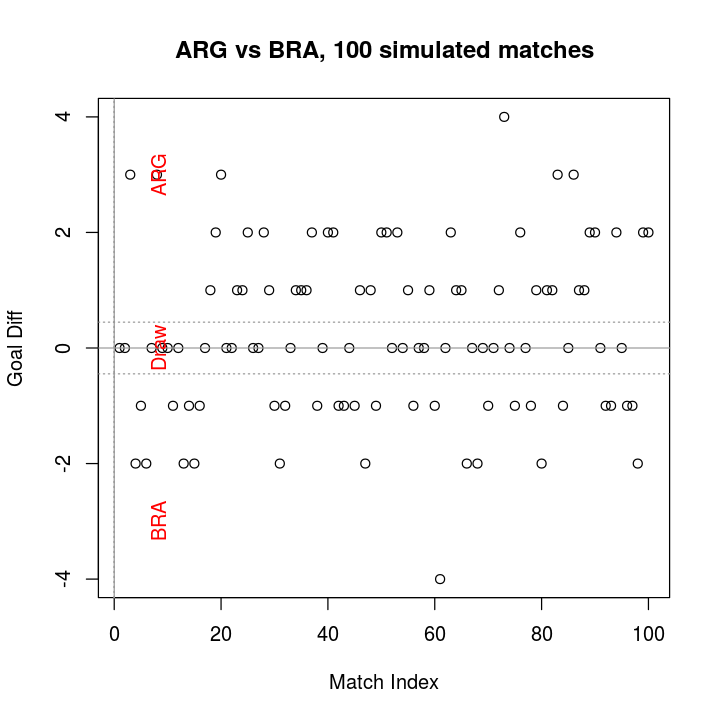

In [154]:
set.seed(4342)
draw_threshold <- 0.4475

temp2 <- rnorm(100, temp$outcome, temp$sd)
temp2

plot(round(temp2),xlab="Match Index",ylab="Goal Diff", main="ARG vs BRA, 100 simulated matches")
abline(h = 0, v = 0, col = "gray60")
abline(h = -0.4475, v = 0, col = "gray60", lty=3)
abline(h = +0.4475, v = 0, col = "gray60", lty=3)
mtext(c("BRA","Draw","ARG"),side=2,line=-3,at=c(-3,0,3),col= "red")

paste("ARG won", length(temp2[temp2 > +draw_threshold]), "matches.")
paste("BRA won", length(temp2[temp2 < -draw_threshold]), "matches.")
paste(length(temp2[temp2 >= -draw_threshold & temp2 <= +draw_threshold]), "matches drawn.")

The points in the above graph are individual outcomes (goal differentials) which we can round to the nearest integer, or to a predicted draw - in the case of values that are "close enough" to zero.

Let's have a look at the result distribution for the real-world matches between these two teams:

[1] "ARG won 10 matches."

[1] "BRA won 15 matches."

[1] "10 matches drawn."

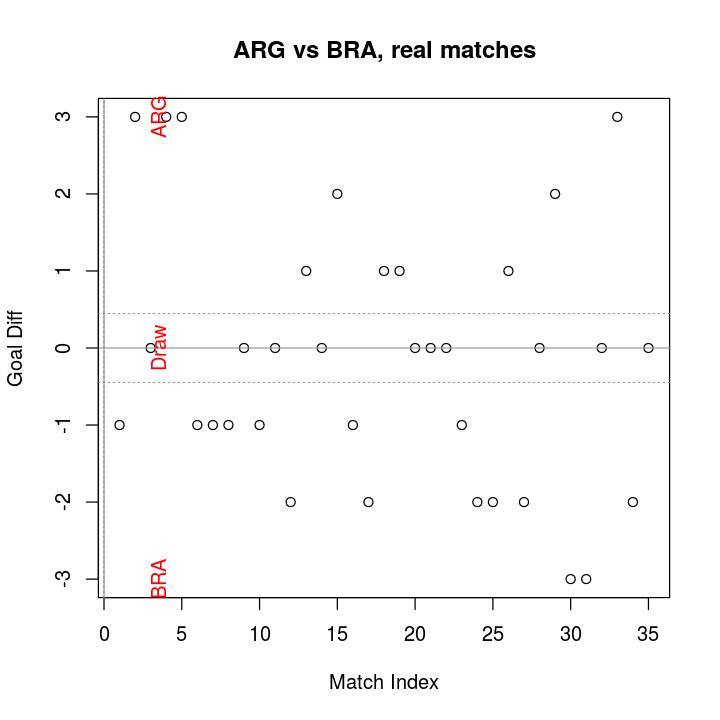

In [155]:
# real results of ARG vs BRA matches
temp <- as.vector(teamperf %>% filter(name == "ARG" & opponentName == "BRA") %>% dplyr::select(gd))

plot(temp$gd,xlab="Match Index",ylab="Goal Diff", main="ARG vs BRA, real matches")
abline(h = 0, v = 0, col = "gray60")
abline(h = -0.4475, v = 0, col = "gray60", lty=3)
abline(h = +0.4475, v = 0, col = "gray60", lty=3)
mtext(c("BRA","Draw","ARG"),side=2,line=-3,at=c(-3,0,3),col= "red")

paste("ARG won", nrow(temp %>% dplyr::filter(gd > 0)), "matches.")
paste("BRA won", nrow(temp %>% dplyr::filter(gd < 0)), "matches.")
paste(nrow(temp %>% dplyr::filter(gd == 0)), "matches drawn.")

For comparison, let's also generate a plot for outcomes of a more unbalanced match-up: Argentina vs Egypt. Incidentally, these two teams have NEVER met in an official match before.

team1,team2,outcome,sd
ARG,EGY,1.6696,2.064019


[1] "ARG won 72 matches."

[1] "EGY won 12 matches."

[1] "16 matches drawn."

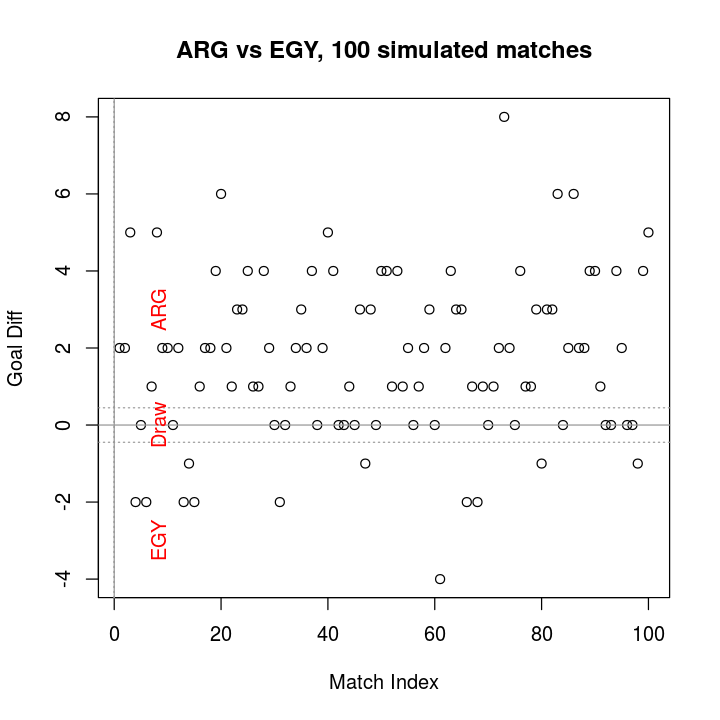

In [145]:
set.seed(4342)

temp <- data.staticpred %>% dplyr::filter(team1 == "ARG" & team2 == "EGY")
temp

temp2 <- rnorm(100, temp$outcome, temp$sd)

plot(round(temp2),xlab="Match Index",ylab="Goal Diff", main="ARG vs EGY, 100 simulated matches")
abline(h = 0, v = 0, col = "gray60")
abline(h = -0.4475, v = 0, col = "gray60", lty=3)
abline(h = +0.4475, v = 0, col = "gray60", lty=3)
mtext(c("EGY","Draw","ARG"),side=2,line=-3,at=c(-3,0,3), col="red")

paste("ARG won", length(temp2[temp2 > +draw_threshold]), "matches.")
paste("EGY won", length(temp2[temp2 < -draw_threshold]), "matches.")
paste(length(temp2[temp2 >= -draw_threshold & temp2 <= +draw_threshold]), "matches drawn.")

As we can see, starting from a rather inconspicuous-looking prediction we can generate a number of possible match results which, while respecting a World Cup's surprising nature, is still in line with what experience tells us *should* happen.

## Tournament Statistics

Now that we're armed with a way of generating multiple predictions for every possible game in the World Cup, we can write a [rather straightforward program](https://github.com/neaorin/PredictTheWorldCup/blob/master/src/TournamentSim/simulateworldcup.py) to run the tournament a large number of times - for example 10,000 iterations. 

We can save our predictions to a CSV file and use it as input for the simulator program.

In [118]:
write_csv(data.staticpred, "wc2018staticPredictions.csv")

Now we can run the program. You simply need [Python 3.x](https://www.python.org/downloads/) installed in order to run it.

Clone the [GitHub repository](https://github.com/neaorin/PredictTheWorldCup), then `cd` to the correct folder, and run it.

Assuming a Windows machine, the steps you need to perform should look like the following, with Python 3 already installed:

```bat
git clone https://github.com/neaorin/PredictTheWorldCup.git
cd PredictTheWorldCup\src\TournamentSim
python simulateworldcup.py
```

On a Linux or Mac the steps should be similar.

The program will output a list of tournament winners (one for each iteration) to a `simresults.csv` file. 

The R code that's going to run after this step will attempt to download a version of this file from the GitHub repository; however, if you ran the Python program yourself and would like to use your own `simresults.csv` file, you can simply upload it into this Azure Notebook library by using the `Data / Upload...` menu at the top of this notebook.

Once we have the results inside the `simresults.csv` file, we can load it up into R and see who won tournaments, and who didn't:

In [119]:
# Load the results of the simulation program

if(!file.exists("simresults.csv")){
    tryCatch(download.file('https://raw.githubusercontent.com/neaorin/PredictTheWorldCup/master/src/TournamentSim/simresults.csv'
                           ,destfile="./simresults.csv",method="auto"))
}
                
if(file.exists("simresults.csv")) simresults <- read_csv("simresults.csv")
    
head(simresults, 20)

Parsed with column specification:
cols(
  iteration = col_integer(),
  winner = col_character()
)


iteration,winner
1,GER
2,FRA
3,FRA
4,GER
5,GER
6,ARG
7,BEL
8,GER
9,FRA
10,SUI


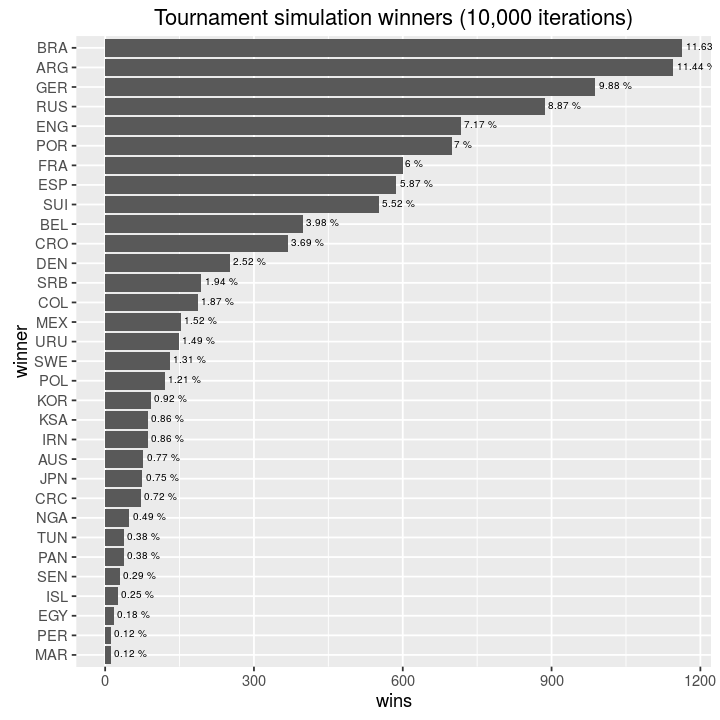

In [146]:
# plot the winners

winsperteam <- simresults %>%
  dplyr::group_by(winner) %>%
  dplyr::summarize(
    wins = n()
  ) %>%
  dplyr::arrange(desc(wins)) 

winsperteam$winner <- factor(winsperteam$winner, levels = winsperteam$winner[order(winsperteam$wins, decreasing = FALSE)])

ggplot(winsperteam, mapping = aes(x=winner, y=wins)) +
  geom_bar(stat="identity") +
  coord_flip() +
  geom_text(aes(label=paste(wins / 100, "%")), vjust=0.3, hjust=-0.1, size=2.1) +
  ggtitle("Tournament simulation winners (10,000 iterations)")

Just for fun, let's calculate the odds to win the tournament predicted by our model:

In [121]:
# calculate the sports odds 

winsperteam$odds <- lengths(simresults) / winsperteam$wins
writeLines(paste(winsperteam$winner, ": ",round(winsperteam$odds), " to 1\n"))

BRA :  9  to 1

ARG :  9  to 1

GER :  10  to 1

RUS :  11  to 1

ENG :  14  to 1

POR :  14  to 1

FRA :  17  to 1

ESP :  17  to 1

SUI :  18  to 1

BEL :  25  to 1

CRO :  27  to 1

DEN :  40  to 1

SRB :  52  to 1

COL :  53  to 1

MEX :  66  to 1

URU :  67  to 1

SWE :  76  to 1

POL :  83  to 1

KOR :  109  to 1

IRN :  116  to 1

KSA :  116  to 1

AUS :  130  to 1

JPN :  133  to 1

CRC :  139  to 1

NGA :  204  to 1

PAN :  263  to 1

TUN :  263  to 1

SEN :  345  to 1

ISL :  400  to 1

EGY :  556  to 1

MAR :  833  to 1

PER :  833  to 1



And that's it! We now have a surefire way of making money by betting on sports! 

*(pretty sure I'm not the first person ever to say those words :P)*

Sorin